# Supply and Inventory Planning Optimization Model


In [8]:
# Import Libraries
from pyomo.environ import *
import pyomo.opt as opt
from fpdf import FPDF
import pandas as pd
from amplpy import AMPL
import numpy as np
import matplotlib.pyplot as plt
from fpdf import FPDF
from datetime import datetime, timedelta

ampl = AMPL()    

In [12]:
# 1: Load parameters from .txt and .xlsx files
import ast

parametros = {}
current_key = None
current_value_lines = []

with open('parametros_completos.txt', 'r') as file:
    for line in file:
        line = line.strip()
        if not line or line.startswith('#'):
            continue
        
        if '=' in line:
            # Process the previous block if it exists
            if current_key is not None:
                # Join the accumulated lines into a single string
                value_str = '\n'.join(current_value_lines)
                try:
                    # Use ast.literal_eval for safe evaluation of the value
                    parametros[current_key] = ast.literal_eval(value_str)
                except (ValueError, SyntaxError):
                    print(f"Error evaluating line: {current_key} = {value_str}")
                    parametros[current_key] = value_str  # Save as string if evaluation fails

            # Process the new line
            current_key, value_part = line.split('=', 1)
            current_key = current_key.strip()
            current_value_lines = [value_part.strip()]  # Start a new block of values
        else:
            # Continue accumulating lines for the current value
            current_value_lines.append(line)

    # Process the last block if it exists
    if current_key is not None:
        value_str = '\n'.join(current_value_lines)
        try:
            parametros[current_key] = ast.literal_eval(value_str)
        except (ValueError, SyntaxError):
            print(f"Error evaluating line: {current_key} = {value_str}")
            parametros[current_key] = value_str
            
# Read the Excel file
file_path = 'parametros6.xlsx'

# Read the 'Periodos' sheet
df_periodos = pd.read_excel(file_path, sheet_name='Periodos')
T = df_periodos['Periodo'].tolist() 

df_insumos = pd.read_excel(file_path, sheet_name='Insumos')
I = df_insumos['Insumo'].tolist() 

df_productos = pd.read_excel(file_path, sheet_name='Productos')
PT = df_productos['Producto'].tolist()

# Read the 'Demanda' sheet
demand_data = pd.read_excel(file_path, sheet_name='Demanda')
stock_insumos_0 = pd.read_excel(file_path, sheet_name='I_0')

# Convert the demand DataFrame to a Pyomo dictionary
demand_data = {(row['Producto'], row['Periodo']): row['Demanda'] for index, row in demand_data.iterrows()}
stock_insumos_0 = {(row['Insumo']): row['Cantidad'] for index, row in stock_insumos_0.iterrows()}

# Convert the consumption DataFrame to a dictionary for Pyomo
cons_data = pd.read_excel(file_path, sheet_name='cons')
cons_dta = {(row['Insumo'], col): row[col] for _, row in cons_data.iterrows() for col in cons_data.columns[1:]}

# 2: Define the Sets for the Pyomo Model
model = ConcreteModel()

# Sets
model.I = Set(initialize=I)
model.PT = Set(initialize=PT)
model.T = Set(initialize=T)

# 3: Define the Parameters for the Model
# Parameters
pr = parametros['pr']
c = parametros['c']
t = parametros['t']
l = parametros['l']
ss = parametros['ss']
q_min = parametros['q_min']
k = parametros['k']
Pal = parametros['Pal']
Pen = parametros['Pen']
PT_0 = parametros['PT_0']
TIE = parametros['TIE']
fecha_actual = parametros['fecha_actual']
k_max = parametros['k_max']
c_prod = parametros['c_prod']
PN = 1000000000  # Penalty for negative inventory
backorder_cost = parametros['backorder_cost']
nivel_final_minimo = 0.8;

# Define Pyomo Parameters with non-negative domain
model.d = Param(model.PT, model.T, initialize=demand_data, within=NonNegativeReals)  # Demand
model.pr = Param(model.I, initialize=lambda model, i: pr[i], within=NonNegativeReals)  # Unit price of inputs
model.l = Param(initialize=l, within=NonNegativeReals)  # Lead time as scalar
model.t_cost = Param(initialize=t, within=NonNegativeReals)  # Transportation cost per pallet as scalar
model.ss = Param(model.PT, initialize=lambda model, p: ss[p], within=NonNegativeReals)  # Safety stock per product
model.q_min = Param(model.I, initialize=lambda model, i: q_min[i], within=NonNegativeReals)  # Minimum order quantity
model.k = Param(initialize=k, within=NonNegativeReals)  # Truck capacity
model.Pal = Param(model.I, initialize=lambda model, i: Pal[i], within=NonNegativeReals)  # Units of input per pallet
model.Pen = Param(model.I, initialize=lambda model, i: Pen[i], within=NonNegativeReals)  # Penalty
model.cons = Param(model.I, model.PT, initialize=cons_dta, within=NonNegativeReals)  # Input consumption per product
model.I_0 = Param(model.I, initialize=stock_insumos_0, within=NonNegativeReals)  # Initial stock of inputs
model.PT_0 = Param(model.PT, initialize=lambda model, p: PT_0[p], within=NonNegativeReals)  # Initial stock of finished products
model.TIE = Param(initialize=TIE, within=NonNegativeReals)  # Effective interest rate
model.k_max = Param(initialize=k_max, within=NonNegativeReals)  # Weekly factory processing capacity
model.c_prod = Param(model.PT, initialize=lambda model, p: c_prod[p], within=NonNegativeReals)  # Production cost (to limit unlimited production)
model.backorder_cost = Param(model.PT, initialize=lambda model, p: 5.0)  # Backorder cost
model.nivel_final_minimo = Param(initialize=nivel_final_minimo, within=NonNegativeReals)  # Final inventory level as a percentage of initial

# Step 4: Define Decision Variables
model.q = Var(model.I, model.T, domain=NonNegativeIntegers, initialize=0)  # Order quantity
model.x = Var(model.I, model.T, domain=Binary, initialize=0)  # Whether an order is placed
model.y = Var(model.I, model.T, domain=NonNegativeIntegers, initialize=0)  # Inventory of inputs
model.z = Var(model.I, model.T, domain=NonNegativeIntegers, initialize=0)  # Pallets needed
model.y_pt = Var(model.PT, model.T, domain=Reals, initialize=0)  # Inventory of finished products
model.penalidad_negativa = Var(model.PT, model.T, within=NonNegativeIntegers, initialize=0)  # Positive penalty
model.cu = Var(model.T, within=Binary, initialize=0)  # Binary variable indicating truck usage
model.pro = Var(model.PT, model.T, domain=NonNegativeIntegers, initialize=0)  # Production quantity
model.backorder = Var(model.PT, model.T, within=NonNegativeReals)  # Backorder quantity
model.penalidad = Var(model.I, model.T, domain=Binary, initialize=0)  # Penalty for not meeting minimum order
model.penalidad2 = Var(model.I, model.T, domain=Binary, initialize=0)  # Penalty for another condition
model.penalidad3 = Var(model.I, model.T, domain=Binary, initialize=0)  # Penalty for a third condition


In [14]:
# Step 5: Define the Objective Function
def objetivo_rule(model):
    return sum(
        # Cost of maintaining inventory of inputs
        model.pr[i] * (c + model.TIE / 52) * model.y[i, t] +  # Storage cost
        model.t_cost * model.cu[t] +  # Fixed truck cost
        model.Pen[i] * model.penalidad3[i, t]  # Penalty for not meeting minimum order
        for i in model.I for t in model.T
    ) + sum(
        + (c + model.TIE / 52) * c_prod[p] * model.y_pt[p, t]  # Storage cost of finished products
        + PN * model.penalidad_negativa[p, t] +  # Penalty for negative inventory of products
        + model.c_prod[p] * model.pro[p, t]  # Production cost
        + model.backorder_cost[p] * model.backorder[p, t]  # Backorder cost
        for p in model.PT for t in model.T
    )
model.objetivo = Objective(rule=objetivo_rule, sense=minimize)

# Step 6: Define Constraints
# Constraint for initial inventory of inputs (t = 0)
def inventario_insumos_inicial_rule(model, i):
    return model.y[i, 0] == model.I_0[i]  # Initial inventory of inputs
model.inventario_insumos_inicial = Constraint(model.I, rule=inventario_insumos_inicial_rule)

# Constraint for initial inventory of finished products (t = 0)
def inventario_productos_inicial_rule(model, p):
    return model.y_pt[p, 0] == model.PT_0[p]  # Initial inventory of finished products
model.inventario_productos_inicial_rule = Constraint(model.PT, rule=inventario_productos_inicial_rule)

# Constraint for updating inventory of finished products (t > 0)
def inventario_productos_actualizacion_rule(model, p, t):
    return model.y_pt[p, t] == model.y_pt[p, t-1] - model.d[p, t-1] + model.pro[p, t-1]
model.inventario_productos_actualizacion = Constraint(model.PT, model.T - {0}, rule=inventario_productos_actualizacion_rule)

# Constraint for total inventory of inputs
def inventario_total_actualizacion_rule(model, i, t):
    conversion_insumos_pt = sum(model.cons[i, p] * model.pro[p, t] for p in model.PT)
    return model.y[i, t] == model.y[i, t-1] + model.q[i, t] - conversion_insumos_pt
model.inventario_total_actualizacion = Constraint(model.I, model.T - {0}, rule=inventario_total_actualizacion_rule)

# Constraint for production capacity
def capacidad_de_produccion(model, p, t):
    return model.pro[p, t] <= model.k_max * model.d[p, t]
model.capacidad_produccion = Constraint(model.PT, model.T, rule=capacidad_de_produccion)

# Constraint for truck capacity
def capacidad_camion_rule(model, t):
    return sum(model.z[i, t] for i in model.I) == model.k * model.cu[t]  # Restricted by truck capacity
model.capacidad_camion = Constraint(model.T, rule=capacidad_camion_rule)

# Constraint for truck usage
def uso_camion_rule(model, t):
    return model.cu[t] >= sum(model.z[i, t] for i in model.I) / model.k
model.uso_camion = Constraint(model.T, rule=uso_camion_rule)

# Constraint for order quantities being multiples of pallet sizes
def pallets_multiples_rule(model, i, t):
    return model.q[i, t] == model.z[i, t] * model.Pal[i]
model.pallets_multiples = Constraint(model.I, model.T, rule=pallets_multiples_rule)

# Constraint for penalty on negative product inventory
def penalizacion_inventario_negativo_rule(model, p, t):
    return model.penalidad_negativa[p, t] >= -model.y_pt[p, t]
model.penalizacion_inventario_negativo_restriccion = Constraint(model.PT, model.T, rule=penalizacion_inventario_negativo_rule)

# Constraint for penalty being non-negative
def penalizacion_no_negativa_rule(model, p, t):
    return model.penalidad_negativa[p, t] >= 0
model.penalizacion_no_negativa_restriccion = Constraint(model.PT, model.T, rule=penalizacion_no_negativa_rule)

# Modify stock constraint to include backorders
def backorder_penalty_rule(model, p, t):
    return model.y_pt[p, t] + model.backorder[p, t] >= model.ss[p] + model.l * model.d[p, t]
model.BackorderPenalty = Constraint(model.PT, model.T, rule=backorder_penalty_rule)

# Penalty constraints for unmet minimum order
def penalidad_rule(model, i, t):
    return model.penalidad[i, t] * 10000000000 >= model.q_min[i] - model.q[i, t]
model.penalidad_restriccion = Constraint(model.I, model.T, rule=penalidad_rule)

def penalidad_rule2(model, i, t):
    return model.penalidad2[i, t] * 10000000000 >= model.q[i, t]
model.penalidad_restriccion2 = Constraint(model.I, model.T, rule=penalidad_rule2)

def penalidad_rule3(model, i, t):
    return model.penalidad3[i, t] >= (model.penalidad[i, t] + model.penalidad2[i, t]) / 2 - 0.9
model.penalidad_restriccion3 = Constraint(model.I, model.T, rule=penalidad_rule3)

# Constraint for final inventory of inputs
def inventario_final_insumos_rule1(model, i):
    return model.y[i, max(model.T)] >= 0  # Ensures non-negative inventory
model.inventario_final_insumos1 = Constraint(model.I, rule=inventario_final_insumos_rule1)

# Constraint for final inventory of finished products
def inventario_final_productos_rule1(model, p):
    return model.y_pt[p, max(model.T)] >= 0  # Ensures non-negative inventory
model.inventario_final_productos1 = Constraint(model.PT, rule=inventario_final_productos_rule1)

# Constraint for final inventory level of inputs
def inventario_final_insumos_rule(model, i):
    return model.y[i, max(model.T)] >= model.I_0[i] * model.nivel_final_minimo
model.inventario_final_insumos = Constraint(model.I, rule=inventario_final_insumos_rule)

# Constraint for final inventory level of finished products
def inventario_final_productos_rule(model, p):
    return model.y_pt[p, max(model.T)] >= model.PT_0[p] * model.nivel_final_minimo
model.inventario_final_productos = Constraint(model.PT, rule=inventario_final_productos_rule)

# Uncomment the following lines to deactivate final inventory constraints
# model.inventario_final_insumos.deactivate()
# model.inventario_final_productos.deactivate()  # Deactivates balance for final inventory to reduce resolution time


Restricted license - for non-production use only - expires 2025-11-24
Read LP format model from file /var/folders/0p/s6c7y_lj66q92j49z14qm1vh0000gn/T/tmpuwawo3yz.pyomo.lp
Reading time = 0.00 seconds
x1: 1031 rows, 975 columns, 2347 nonzeros
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 21.6.0 21G115)

CPU model: Intel(R) Core(TM) i5-8210Y CPU @ 1.60GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 1031 rows, 975 columns and 2347 nonzeros
Model fingerprint: 0x454931f6
Variable types: 210 continuous, 765 integer (285 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+10]
  Objective range  [1e-05, 1e+09]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-01, 1e+05]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 941 rows and 748 columns
Presolve time: 0.00s
Presolved: 90 rows, 227 columns, 453 nonzeros
Variable types: 0

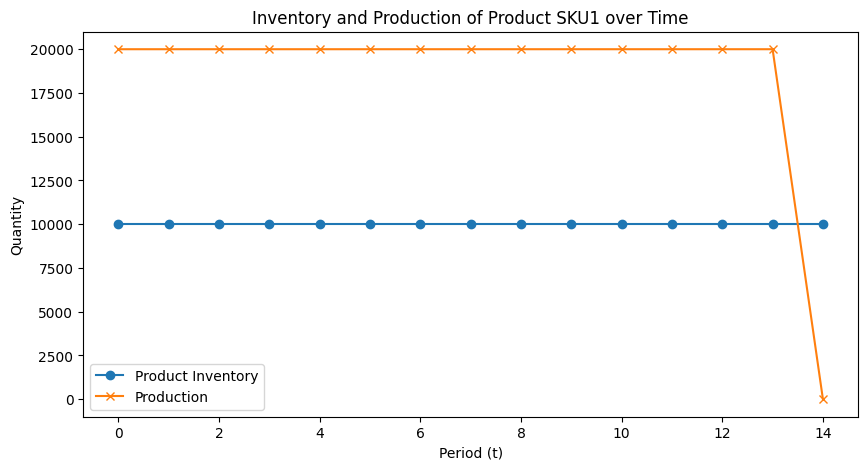

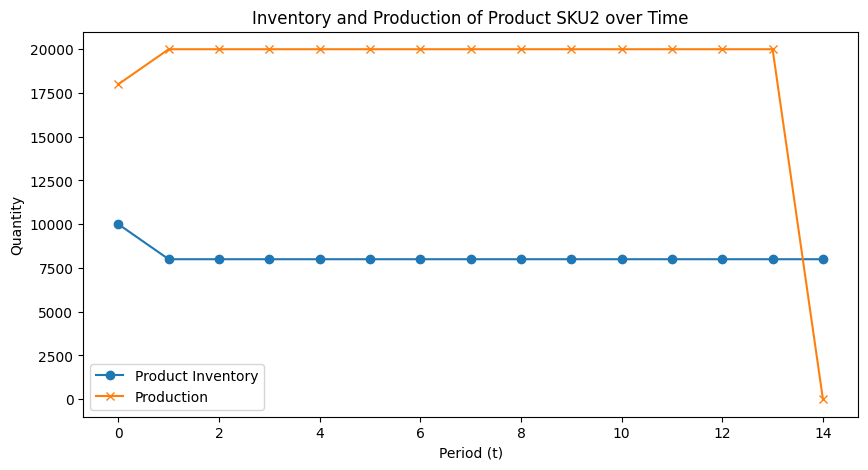

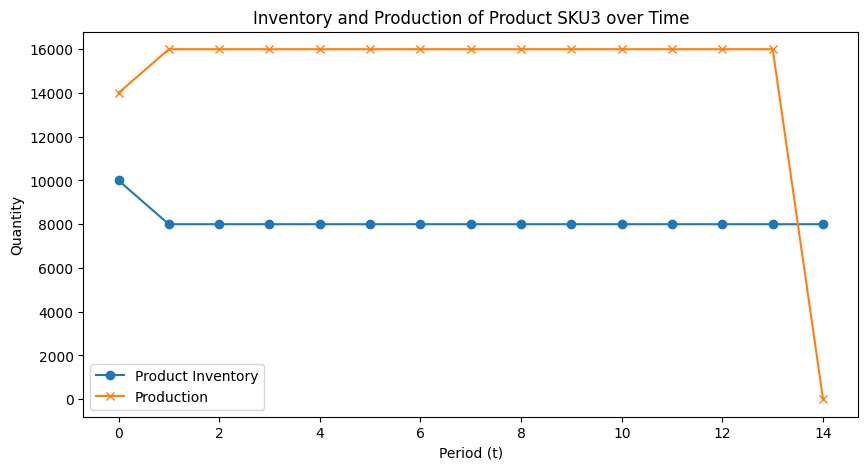

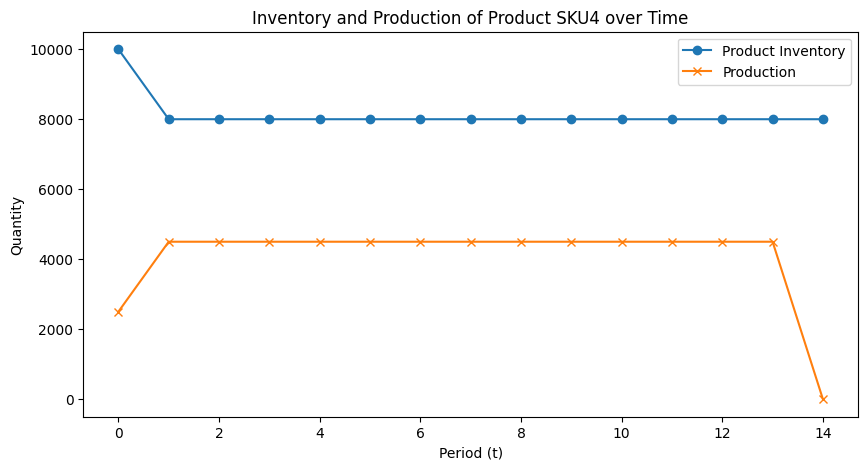

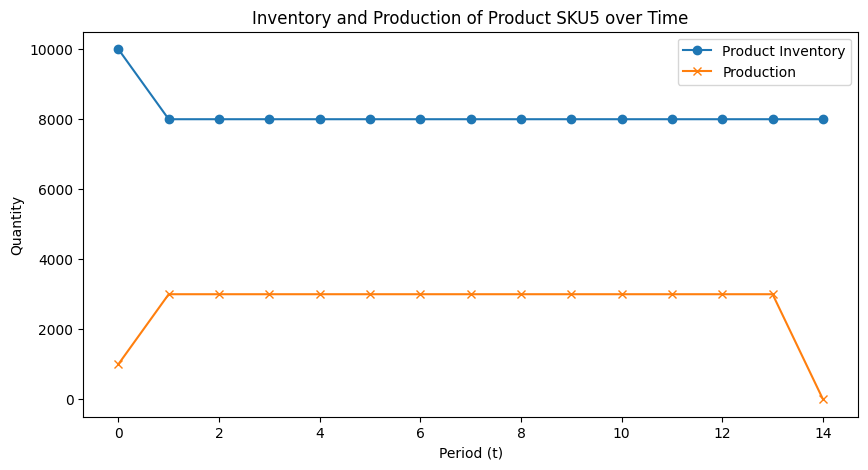

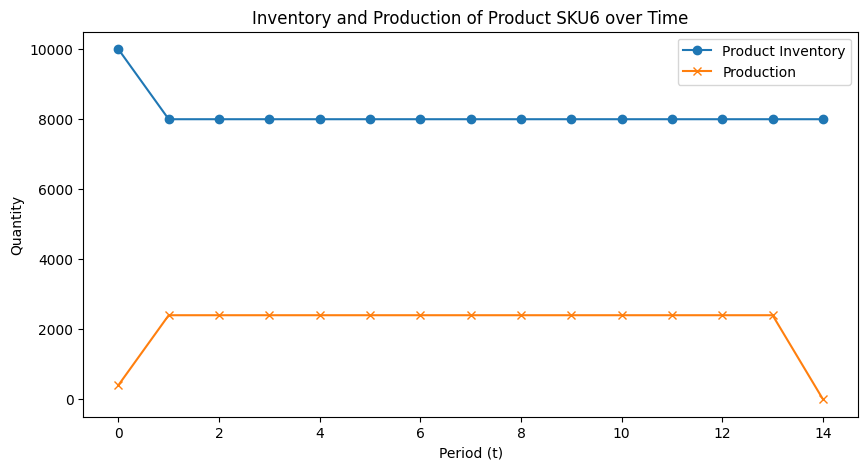

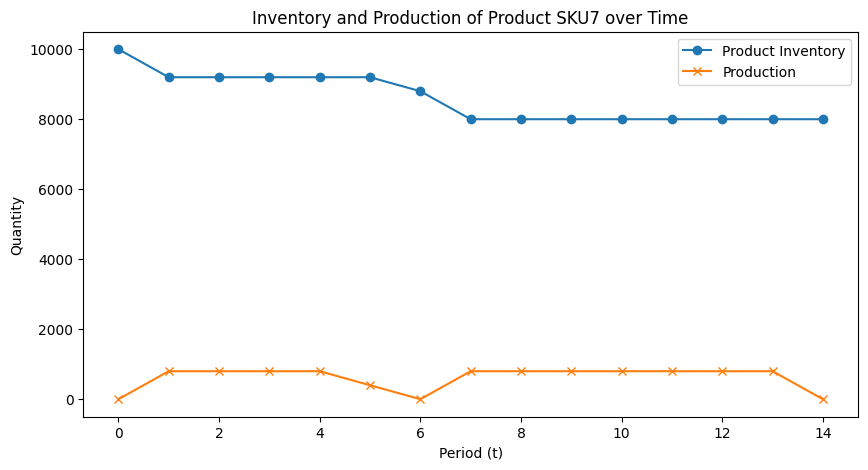

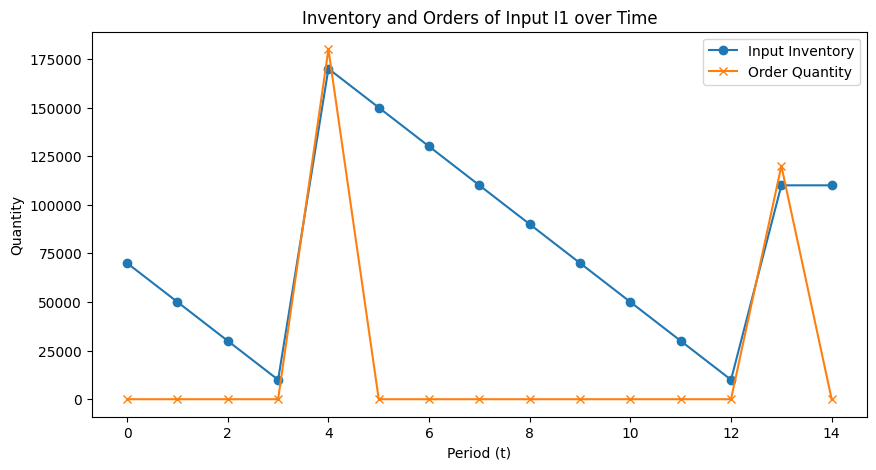

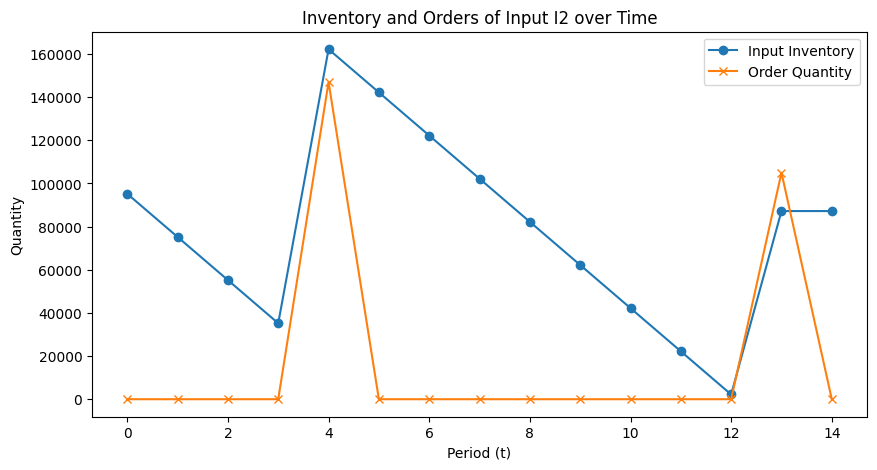

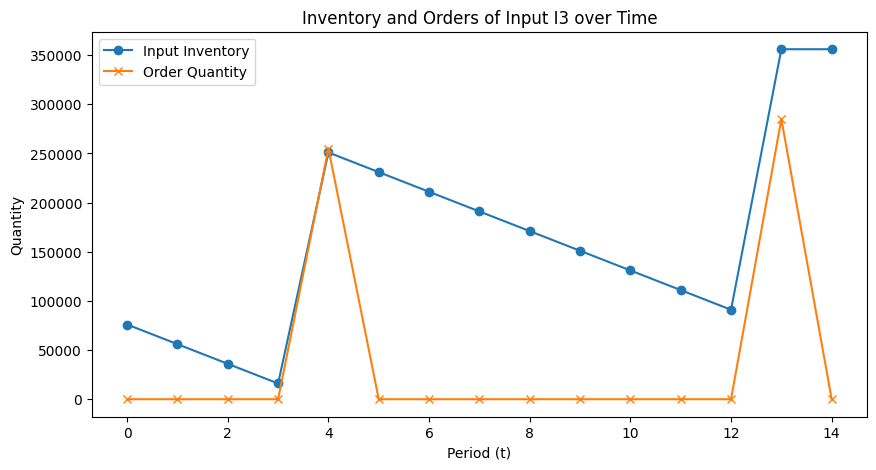

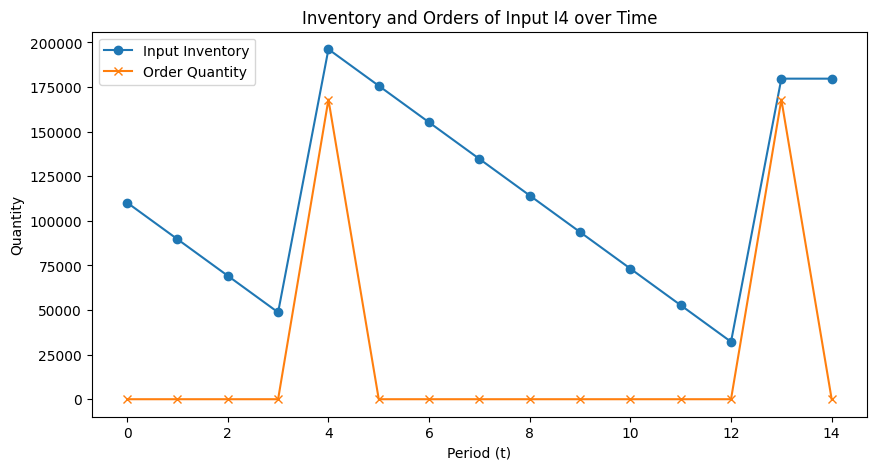

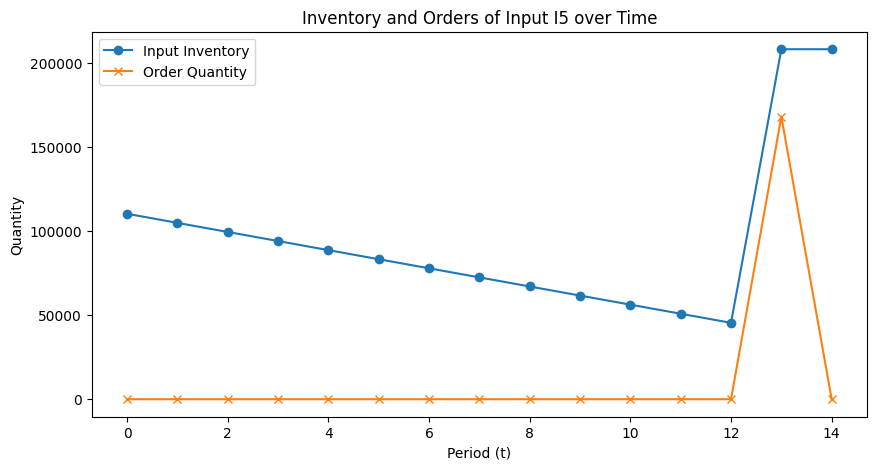

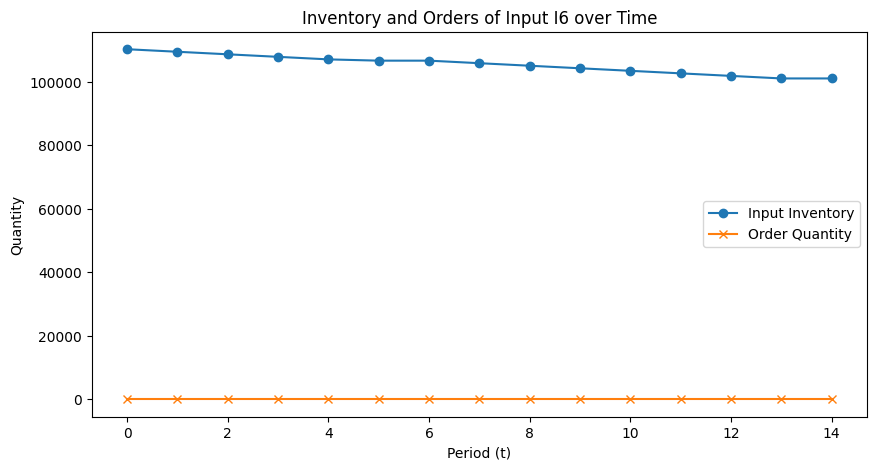

In [17]:
# Model solution
solver = SolverFactory('gurobi')
# Set the time limit (in seconds)
#solver.options['tmlim'] = 60

results = solver.solve(model, tee=True)

# Save the solution to a .json file
results.write(filename='model_solution.json', format='json')

# Check the optimization status
print("Optimization Status:", results.solver.termination_condition)
if results.solver.termination_condition == TerminationCondition.infeasible:
    print("The model is infeasible. Check the parameters and constraints.")
else:
    # Step 8: Save Results in DataFrames
    orders = []
    input_inventories = []
    product_inventories = []
    trucks_used = []
    product_production = []

    for i in model.I:
        for t in model.T:
            orders.append({'Input': i, 'Period': t, 'Order Quantity': model.q[i, t].value})
            input_inventories.append({'Input': i, 'Period': t, 'Input Inventory': model.y[i, t].value})

    for p in model.PT:
        for t in model.T:
            product_inventories.append({'Product': p, 'Period': t, 'Product Inventory': model.y_pt[p, t].value})
            product_production.append({'Product': p, 'Period': t, 'Production': model.pro[p, t].value})

    for t in model.T:
        trucks_used.append({'Period': t, 'Trucks Used': model.cu[t].value})

    # Convert lists to DataFrames
    df_orders = pd.DataFrame(orders)
    df_input_inventories = pd.DataFrame(input_inventories)
    df_product_inventories = pd.DataFrame(product_inventories)
    df_product_production = pd.DataFrame(product_production)
    df_trucks_used = pd.DataFrame(trucks_used)

    # Export to Excel file
    with pd.ExcelWriter('model_solution.xlsx') as writer:
        df_orders.to_excel(writer, sheet_name='Orders', index=False)
        df_input_inventories.to_excel(writer, sheet_name='Input Inventories', index=False)
        df_product_inventories.to_excel(writer, sheet_name='Product Inventories', index=False)
        df_product_production.to_excel(writer, sheet_name='Product Production', index=False)
        df_trucks_used.to_excel(writer, sheet_name='Trucks Used', index=False)

    # Display results
    print("Minimum total cost:", model.objetivo())

    # Plot inventory and production of finished products over time
    for p in model.PT:
        plt.figure(figsize=(10, 5))
        plt.plot(df_product_inventories[df_product_inventories['Product'] == p]['Period'],
                 df_product_inventories[df_product_inventories['Product'] == p]['Product Inventory'],
                 marker='o', label='Product Inventory')
        plt.plot(df_product_production[df_product_production['Product'] == p]['Period'],
                 df_product_production[df_product_production['Product'] == p]['Production'],
                 marker='x', label='Production')
        plt.title(f'Inventory and Production of Product {p} over Time')
        plt.xlabel('Period (t)')
        plt.ylabel('Quantity')
        plt.legend()
        plt.show()

    # Plot inventory and orders of inputs over time
    for i in model.I:
        plt.figure(figsize=(10, 5))
        plt.plot(df_input_inventories[df_input_inventories['Input'] == i]['Period'],
                 df_input_inventories[df_input_inventories['Input'] == i]['Input Inventory'],
                 marker='o', label='Input Inventory')
        plt.plot(df_orders[df_orders['Input'] == i]['Period'],
                 df_orders[df_orders['Input'] == i]['Order Quantity'],
                 marker='x', label='Order Quantity')
        plt.title(f'Inventory and Orders of Input {i} over Time')
        plt.xlabel('Period (t)')
        plt.ylabel('Quantity')
        plt.legend()
        plt.show()


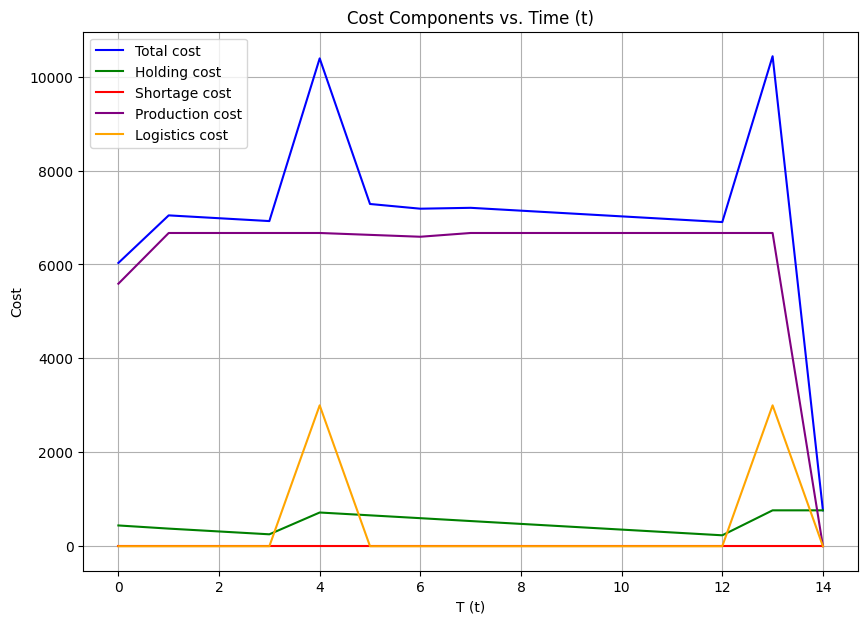

In [19]:
# COST COMPONENTS GRAPH
T_values = list(model.T)
holding_costs = []  
shortage_costs = []  
production_costs = []  
logistics_costs = []  
total_costs = []  

# Calculate costs for each period t
for t in T_values:
    #fixed_cost = model.t_cost * model.cu[t].value  # Fixed/logistics cost associated with truck usage
    holding_cost = sum(c * model.y[i, t].value + c * model.y_pt[p, t].value for i in model.I for p in model.PT)
    shortage_cost = sum(Pen[i] * model.penalidad3[i, t].value for i in model.I) + sum(PN * model.penalidad_negativa[p, t].value for p in model.PT)
    production_cost = sum(c_prod[p] * model.pro[p, t].value for p in model.PT)
    logistics_cost = model.t_cost * model.cu[t].value  # Logistics cost, same as the fixed cost in this case
    total_cost = holding_cost + shortage_cost + production_cost + logistics_cost

    # Store the results
    #fixed_costs.append(fixed_cost)
    holding_costs.append(holding_cost)
    shortage_costs.append(shortage_cost)
    production_costs.append(production_cost)
    logistics_costs.append(logistics_cost)
    total_costs.append(total_cost)
    
# Plot the results
plt.figure(figsize=(10, 7))

plt.plot(T_values, total_costs, label='Total cost', color='blue')
plt.plot(T_values, holding_costs, label='Holding cost', color='green')
#plt.plot(T_values, fixed_costs, label='Fixed cost', color='black')
plt.plot(T_values, shortage_costs, label='Shortage cost', color='red')
plt.plot(T_values, production_costs, label='Production cost', color='purple')
plt.plot(T_values, logistics_costs, label='Logistics cost', color='orange')

plt.xlabel('T (t)')
plt.ylabel('Cost')
plt.title('Cost Components vs. Time (t)')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
# Paso 1: Crear la clase PDF
class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 12)
        self.cell(0, 10, 'Orden de Compra', 0, 1, 'C')
        self.ln(10)

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.cell(0, 10, f'Página {self.page_no()}', 0, 0, 'C')

# Paso 2: Crear la función para generar el PDF
def generar_orden_compra(model, fecha_inicio):
    # Encontrar el primer periodo en el que se utiliza un camión
    periodo_orden = None
    for t in model.T:
        if model.cu[t].value > 0:  # Si un camión es usado en este período
            periodo_orden = t
            break

    if periodo_orden is None:
        print("No hay ningún período con uso de camión.")
        return

    # Calcular la semana del año correspondiente al período de orden
    fecha_inicio = datetime.strptime(fecha_inicio, "%Y-%m-%d")
    fecha_periodo = fecha_inicio + timedelta(weeks=periodo_orden)
    semana_del_anio = fecha_periodo.isocalendar()[1]

    # Calcular el primer día (lunes) de esa semana del año
    primer_dia_semana = fecha_periodo - timedelta(days=fecha_periodo.weekday())

    pdf = PDF()
    pdf.add_page()
    pdf.set_font('Arial', 'B', 12)
    pdf.cell(0, 10, f'Orden de Compra - Semana {semana_del_anio} del Año {fecha_periodo.year} (Inicio: {primer_dia_semana.strftime("%d/%m/%Y")})', 0, 1)
    pdf.ln(5)
    
    # Encabezados de la tabla
    pdf.set_font('Arial', 'B', 10)
    pdf.cell(60, 10, 'Insumo', 1)  # Aumentar el ancho de la celda para descripciones largas
    pdf.cell(40, 10, 'Precio Unitario', 1)
    pdf.cell(40, 10, 'Cantidad a Ordenar', 1)
    pdf.cell(40, 10, 'Total por Insumo', 1)
    pdf.ln()

    # Paso 3: Iterar sobre los insumos y agregar las cantidades a ordenar para el primer periodo con camión usado
    pdf.set_font('Arial', '', 10)
    total_pagar = 0  # Variable para almacenar el total a pagar

    for i in model.I:
        cantidad_ordenar = model.q[i, periodo_orden].value
        precio_unitario = model.pr[i]  
        total_insumo = precio_unitario * cantidad_ordenar
        
        if cantidad_ordenar > 0:  # Agregar solo si hay una cantidad a ordenar
            pdf.cell(60, 10, i, 1)  # Ajuste de ancho para descripciones largas
            pdf.cell(40, 10, f'{precio_unitario:.2f}', 1)
            pdf.cell(40, 10, f'{cantidad_ordenar:}', 1)
            pdf.cell(40, 10, f'{total_insumo:.2f}', 1)
            pdf.ln()
            total_pagar += total_insumo  # Sumar al total a pagar

    # Paso 4: Imprimir el Total a Pagar
    pdf.set_font('Arial', 'B', 10)
    pdf.cell(140, 10, 'Total a Pagar', 1)
    pdf.cell(40, 10, f'{total_pagar:.2f}', 1)
    pdf.ln()

    # Paso 5: Guardar el PDF
    pdf_output_path = 'orden_de_compra_periodo_{}.pdf'.format(periodo_orden)
    pdf.output(pdf_output_path)
    print(f"Orden de compra guardada como {pdf_output_path}")

# Paso 6: Generar el PDF para el primer período con uso de camión, incluyendo la fecha de inicio del análisis
generar_orden_compra(model, fecha_actual)


Orden de compra guardada como orden_de_compra_periodo_4.pdf
